<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.14.02.Colab_LandCover_Copernicus_100m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Copernicus Land Cover

This notebook uses the Copernicus (CGLS-LC100) land cover product derived from Proba-V over the period of 2015 to 2019. The output shows a land classification (22 classes) map for any selected year. This data can be found in the Google Earth Engine database as "COPERNICUS_Landcover_100m_Proba-V-C3_Global". 

## Instructions for Execution

It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" labels to modify the region of interest and the analysis year.

Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
#import datacube
#dc = datacube.Datacube(app='CGLS_LandCover')
from odc_gee import earthengine
dc = earthengine.Datacube(app='CGLS_LandCover')

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Define the product name
# This data is indexed from Google Earth Engine data sources
product = 'proba_google'

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the sample regions or add a new region. Use the map below to zoom in-or-out to find other regions. Click on the map to view a Lat-Lon position. 

In [5]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Kumasi, Ghana 
lat_long = (6.7, -1.6)
box_size_deg = 0.50

# Calculates the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [6]:
# Define the time range of the dataset
# Data for 2020 and 2021 will be available in 2022
time_range = ('2015', '2019')

In [7]:
# The code below renders a map that can be used to view the region.
display_map(latitude,longitude)

## Load the dataset

In [8]:
dataset = dc.load(product=product,time=time_range,latitude=latitude,longitude=longitude)

In [9]:
# Show the dimensions of the dataset
# The latitude and longitude bounds are in pixels
# The time index is in years 
# The "data variables" data are the classifications
dataset

<xarray.Dataset>
Dimensions:                        (time: 5, latitude: 557, longitude: 558)
Coordinates:
  * time                           (time) datetime64[ns] 2015-01-01 ... 2019-...
  * latitude                       (latitude) float64 6.95 6.949 ... 6.451 6.45
  * longitude                      (longitude) float64 -1.85 -1.849 ... -1.35
    spatial_ref                    int32 4326
Data variables: (12/14)
    discrete_classification        (time, latitude, longitude) int16 50 ... 116
    discrete_classification-proba  (time, latitude, longitude) int16 0 30 ... 35
    forest_type                    (time, latitude, longitude) int16 0 0 ... 0 0
    bare-coverfraction             (time, latitude, longitude) int16 0 0 ... 0 4
    crops-coverfraction            (time, latitude, longitude) int16 0 0 ... 0 4
    grass-coverfraction            (time, latitude, longitude) int16 2 21 ... 27
    ...                             ...
    tree-coverfraction             (time, latitude, longitude) int16 0 13 ... 30
    snow-coverfraction             (time, latitude, longitude) int16 0 0 ... 0 0
    urban-coverfraction            (time, latitude, longitude) int16 98 ... 17
    water-permanent-coverfraction  (time, latitude, longitude) int16 0 0 ... 0 0
    water-seasonal-coverfraction   (time, latitude, longitude) int16 0 0 ... 0 0
    data-density-indicator         (time, latitude, longitude) int16 56 ... 28
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [10]:
# Show data layer indices and corresponding years
# These indices will be used later to view the classification data
pd.DataFrame(list(dataset.time.values.astype('datetime64[Y]').astype(int)+1970),columns=['Year'])

,Year
0,2015
1,2016
2,2017
3,2018
4,2019


### Create classification labels

In [11]:
labels = {0: {'color': '#282828', 'flag': 'unknown'},
          20: {'color': '#FFBB22', 'flag': 'shrubs'},
          30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
          40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
          50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
          60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
          70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
          80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
          90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
          100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
          111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
          112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
          113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
          114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
          115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
          116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
          121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
          122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
          123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
          124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
          125: {'color': '#929900', 'flag': 'open_forest_mixed'},
          126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
          200: {'color': '#000080', 'flag': 'oceans_seas'}}

colors = [label['color'] for label in labels.values()]

### Create color map

In [12]:
cmap = ListedColormap([label['color'] for label in labels.values()])
norm = BoundaryNorm(list(labels.keys())+[201], cmap.N+1)
ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))

### Plot the classification data

In [13]:
# MODIFY HERE

# Choose a single year by its index (listed above)
year_to_show = 4

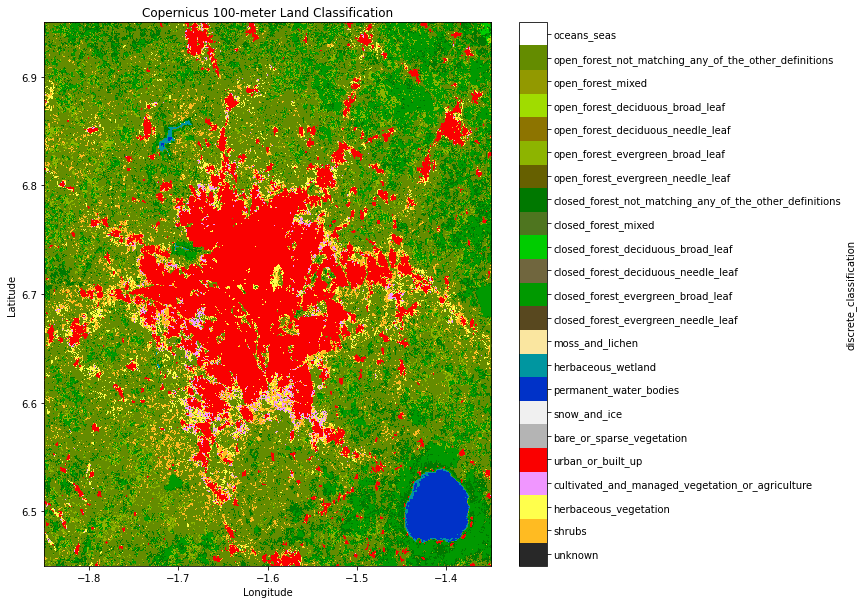

In [14]:
aspect = dataset.dims['longitude']/dataset.dims['latitude']
fig = dataset['discrete_classification'].isel(time=year_to_show).plot.imshow(cmap=cmap, size=10, norm=norm,
                                                                  cbar_kwargs=dict(ticks=ticks),aspect=aspect)
cbar = fig.colorbar
cbar.ax.set_yticklabels(labels=[label['flag'] for label in labels.values()])
plt.title('Copernicus 100-meter Land Classification')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Statistics

In [15]:
print('\033[1;4mTotal number of pixels for each classification.\033[0m')
for val, label in labels.items():
    print(f'{label["flag"]}: {np.sum(dataset.discrete_classification.isel(time=year_to_show).values == val)}')
    
print('\n\033[1;4mPercent of total pixel area.\033[0m')
for val, label in labels.items():
    area = np.sum(dataset.discrete_classification.isel(time=year_to_show).values == val)\
           /dataset.discrete_classification.isel(time=0).size * 100
    print(f'{label["flag"]}: {round(area, 2)}%')

Total number of pixels for each classification.
unknown: 0
shrubs: 15224
herbaceous_vegetation: 9656
cultivated_and_managed_vegetation_or_agriculture: 3702
urban_or_built_up: 51086
bare_or_sparse_vegetation: 0
snow_and_ice: 0
permanent_water_bodies: 4397
herbaceous_wetland: 656
moss_and_lichen: 0
closed_forest_evergreen_needle_leaf: 0
closed_forest_evergreen_broad_leaf: 38194
closed_forest_deciduous_needle_leaf: 0
closed_forest_deciduous_broad_leaf: 140
closed_forest_mixed: 0
closed_forest_not_matching_any_of_the_other_definitions: 26036
open_forest_evergreen_needle_leaf: 0
open_forest_evergreen_broad_leaf: 16361
open_forest_deciduous_needle_leaf: 0
open_forest_deciduous_broad_leaf: 39
open_forest_mixed: 0
open_forest_not_matching_any_of_the_other_definitions: 145315
oceans_seas: 0

Percent of total pixel area.
unknown: 0.0%
shrubs: 4.9%
herbaceous_vegetation: 3.11%
cultivated_and_managed_vegetation_or_agriculture: 1.19%
urban_or_built_up: 16.44%
bare_or_sparse_vegetation: 0.0%
snow_an

### Reference: Classification Descriptions

In [16]:
for val, label in labels.items():
    print(f'\033[1;4m{label["flag"]} ({val})\033[0m\n{dataset.discrete_classification.flags_definition[label["flag"]]["description"]}\n')

unknown (0)
Unknown. No or not enough satellite data available.

shrubs (20)
Shrubs. Woody perennial plants with persistent and woody stems and without any defined main stem being less than 5 m tall. The shrub foliage can be either evergreen or deciduous.

herbaceous_vegetation (30)
Herbaceous vegetation. Plants without persistent stem or shoots above ground and lacking definite firm structure. Tree and shrub cover is less than 10 %.

cultivated_and_managed_vegetation_or_agriculture (40)
Cultivated and managed vegetation / agriculture. Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.

urban_or_built_up (50)
Urban / built up. Land covered by buildings and other man-made structures.

bare_or_sparse_vegetation (60)
Bare / sparse vegetation. Lands with exposed soil, sand, or rocks and never has more than 10 % veget